# Latent Variable Models

In [ ]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

Below you will find the functions which visualizes 2d data and plots the obtained training curves.
Study them carefully but do not change them.

In [ ]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train', fontsize=16)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=16)
    # ax1.set_yticks(fontsize=16)
    ax2.set_title('test', fontsize=16)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=16)
    plt.show()


def visualize_2d_samples(data, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=1)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Here are the functions that we will you for training our model. Please, explore these functions carefully. You do not have to change them.

In [ ]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def get_latent_stats(model, test_data, batch_size=3000):
    batch = next(iter(data.DataLoader(test_data, batch_size=batch_size, shuffle=True)))
    batch = batch.cuda()
    with torch.no_grad():
        
        mu_z, log_std_z = model(batch)[:2]
        
    mu_z = mu_z.cpu().numpy()
    std_z = log_std_z.exp().cpu().numpy()

    return mu_z, std_z

## Task 1 (4 points): VAE on 2d data

In this task you will implement simple VAE model for 2d gaussian distribution.

We will consider two cases: 2d univariate distribution and 2d multivariate distribution. The goal is to analyze the difference between these two cases and chosen VAE model.

Below you will find data generation function. Look carefully, do not change.

In [ ]:
def generate_2d_data(count, mode='univariate'):
    assert mode in ['univariate', 'multivariate']
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == 'univariate':
        rotate = [
            [1.0, 0.0], 
            [0.0, 1.0]
        ]
    else:
        rotate = [
            [np.sqrt(2) / 2, np.sqrt(2) / 2], 
            [-np.sqrt(2) / 2, np.sqrt(2) / 2]
        ]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype('float32')
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

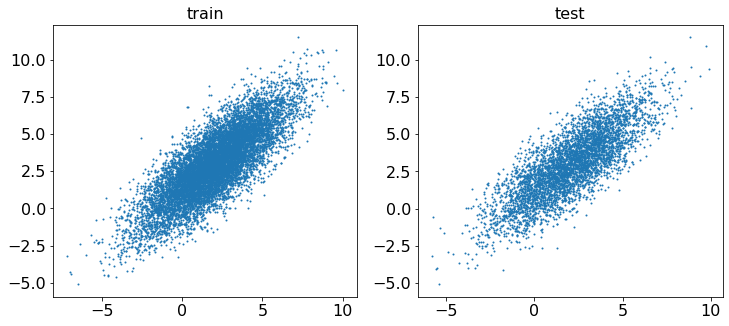

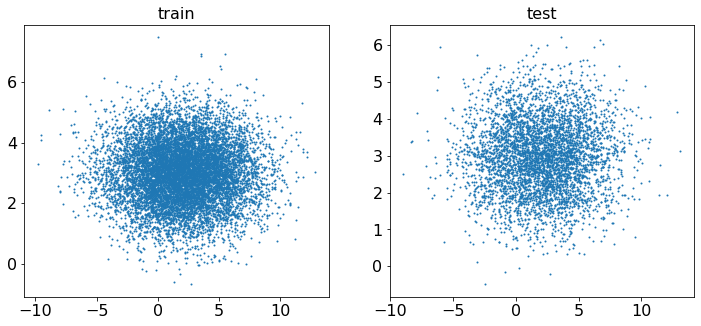

In [ ]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

The difference of these two cases in the form of covariance matrix.

In multivariate case the matrix is non-diagonal, in univariate case it strictly diagonal. As you will see, our VAE model will work absolutely different for these datasets.

Now it is time to define our model. In this task you will create VAE model on 2d data. Model will be designed as:

* the latent dimensionality is equal to 2, the same as the data dimensionality ($\mathbf{z} \in \mathbb{R}^2$, $\mathbf{x} \in \mathbb{R}^2$).
* prior distribution $p(\mathbf{z}) = \mathcal{N}(0, I)$.
* approximate variational distribution (or encoder) $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network.
* generative distribution (or decoder) $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network.
* We will consider only diagonal covariance matrices $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$.

Model objective is ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.

To calculate the loss, you should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, I)$ (the similar, more general task was in your hw2).

In [ ]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []
        # ====
        # your code 
        # Stack some fully connected  (Linear) layers wirh relu activation.
        # Note that you do not have to add relu after the last fc layer
        in_features = input_shape
        for out_features in hiddens:
            model.append(nn.Linear(in_features, out_features))
            model.append(nn.ReLU())
            in_features = out_features
        out_features = output_shape
        model.append(nn.Linear(in_features, out_features))
        # ====
        self.net = nn.Sequential(*model)

    def forward(self, x):
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        return self.net(x)
        # ====


class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, enc_hidden_sizes, 2 * n_in)
        # ====

    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        m = torch.distributions.MultivariateNormal(torch.zeros(self.n_latent), torch.eye(self.n_latent))
        return m.sample((n,)).cuda()
        # ====

    def forward(self, x):
        # ====
        # your code
        # now you have to return from the model 
        # - mu_z - means for variational distribution 
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint
        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        encoder_out = self.encoder(x)
        mu_z = encoder_out[:, :self.n_latent]
        log_std_z = encoder_out[:, self.n_latent:]
        z = self.prior(x.shape[0]) * torch.exp(log_std_z) + mu_z
        decoder_out = self.decoder(z)

        n_out = decoder_out.shape[1] // 2
        mu_x = decoder_out[:, :n_out]
        log_std_x = decoder_out[:, n_out:]
        # ====
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss (it is the first term in ELBO)
        # 3) compute KL loss (it is the second term in ELBO)
        mu_z, log_std_z, mu_x, log_std_x = self.forward(x)
        log2pi = 0.79817986835
        recon_loss = (((x - mu_x) / torch.exp(log_std_x)) ** 2 + log2pi) * (0.5) + log_std_x
        kl_loss = (mu_z ** 2 + torch.exp(2 * log_std_z) - 2 * log_std_z - 1) * (0.5)
        # ====
        recon_loss = recon_loss.sum(1).mean()
        kl_loss = kl_loss.sum(1).mean()

        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n, noise=True):
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if noise=True
            z = self.prior(n) 
            decoder_out = self.decoder(z)
            n_out = decoder_out.shape[1] // 2
            mu = decoder_out[:, :n_out]
            log_std = decoder_out[:, n_out:]
            if noise:
                m = torch.distributions.MultivariateNormal(torch.zeros(n_out), torch.eye(n_out))
                z = m.sample((n,)).cuda()
                z = mu + z * torch.exp(log_std)
            else:
                z = mu
            # ====
        return z.cpu().numpy()


def solve_task(train_data, test_data, model, batch_size, epochs, lr):
    # do not change this function
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
    )
    samples_noise = model.sample(3000, noise=True)
    samples_nonoise = model.sample(3000, noise=False)

    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title='Samples with Decoder Noise')
    visualize_2d_samples(samples_nonoise, title='Samples without Decoder Noise')

In [ ]:
# ====
# your code
# choose these parameters (2 hidden layers could be enough for encoder and decoder)
ENC_HIDDEN_SIZES = [64, 64]
DEC_HIDDEN_SIZES = [64, 64]
BATCH_SIZE = 128
EPOCHS = 50
LR = 5e-4
# ====

COUNT = 10000

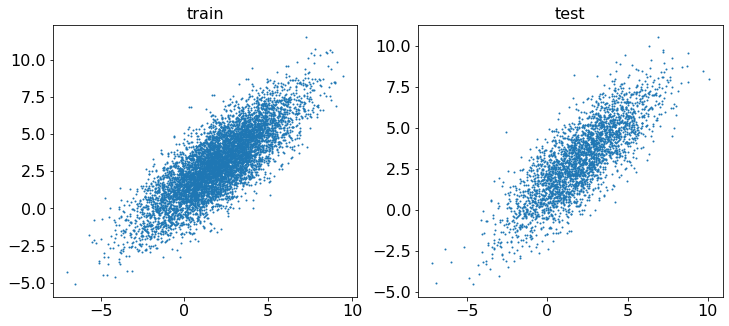

elbo_loss: 2.8996
recon_loss: 1.8004
kl_loss: 1.0992


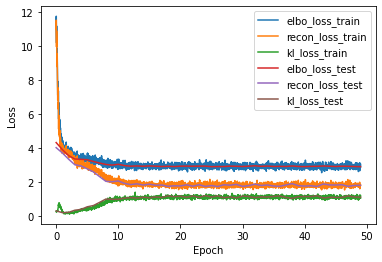

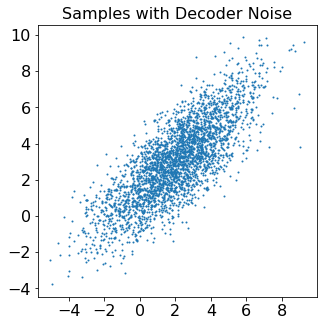

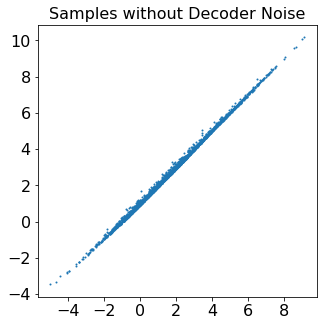

In [ ]:
train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)

In [ ]:
# just look at these numbers and read comments after this task
mu_z, std_z = get_latent_stats(model, test_data)

print('mu_z = ', mu_z.mean(axis=0), '+-', mu_z.std(axis=0))
print('std_z = ', std_z.mean(axis=0), '+-', std_z.std(axis=0))

mu_z =  [0.0165822 0.002392 ] +- [0.9385024  0.02087885]
std_z =  [0.33206213 0.9909353 ] +- [0.00440284 0.02628335]


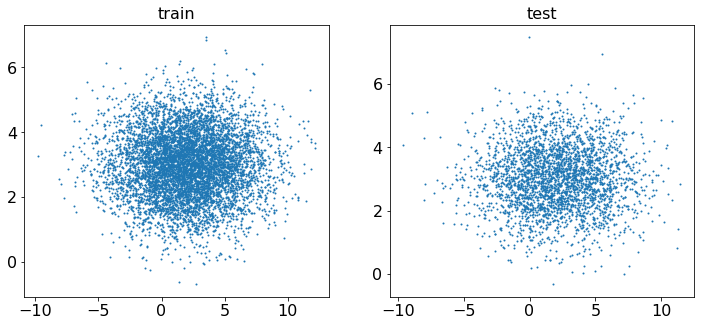

elbo_loss: 2.9100
recon_loss: 2.9012
kl_loss: 0.0088


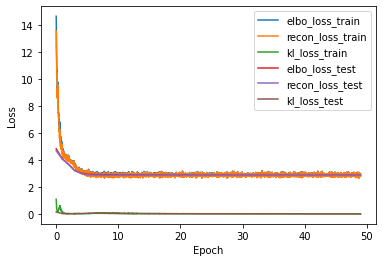

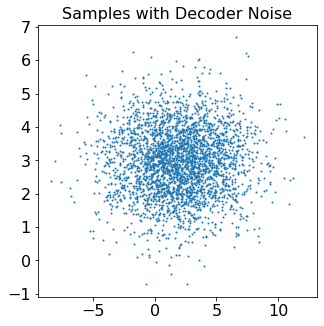

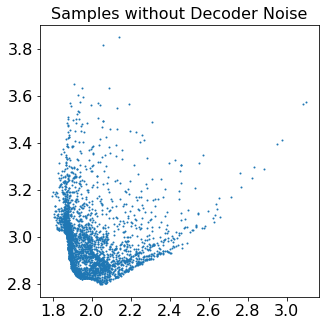

In [ ]:
train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)

In [ ]:
# just look at these numbers and read comments after this task
mu_z, std_z = get_latent_stats(model, test_data)

print('mu_z = ', mu_z.mean(axis=0), '+-', mu_z.std(axis=0))
print('std_z = ', std_z.mean(axis=0), '+-', std_z.std(axis=0))

mu_z =  [0.00097538 0.03302084] +- [0.02345981 0.06949994]
std_z =  [0.98553014 0.981292  ] +- [0.04579266 0.05346161]


After training the model on these 2 datasets, you have to see on "Samples without Decoder Noise" figures. These figures show means of the geerative distribution. In the case of multivariate gaussian, the means are perfectly aligned with data distribution. 
Otherwise, in the univariate gaussian case you have to see strange figure. This happens due to so called "posterior collapse" (we will discuss it on the one of our lecture).

Our posterior distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$ is a univariate (covariance matrix is diagonal). Thus, to model univariate data distribution (second case) the model ignores latent code, cause we could model it without any information from latent space.

If the decoder ignores latent code, the second term in ELBO (KL) could be low (variational disstribution, which is given by encoder model, is close to prior distribution for each datapoint). In the training curves you have to see that KL loss behaves differently in these two cases.

The mean and std of variational distribution also proves this concept. For the second case you have to see that mean is almost zero and std is almost one.

It is a real problem for generative models and we will discuss later how to overcome this problem.

## Task 2 (4 points): VAE on CIFAR10 data

In this task you will implement VAE model for real image distribution.

Look carefully on the following helper functions.

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    return train_data, test_data


def show_samples(samples, title, nrow=10):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

Download data from here: https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing.

In [ ]:
#sorry for downloading code
import gdown
gdown.download('https://drive.google.com/uc?id=16j3nrJV821VOkkuRz7aYam8TyIXLnNme', 'cifar10.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16j3nrJV821VOkkuRz7aYam8TyIXLnNme
To: /content/cifar10.pkl
185MB [00:01, 96.4MB/s]


'cifar10.pkl'

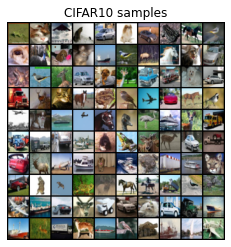

In [ ]:
# change the path to the generated data
train_data, test_data = load_pickle(os.path.join('cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples')

Here the model specification will be almost the same with the following differences:
* Now our encoder and decoder will be convolutional.
* We do not model covariance matrix in generative distribution (now it is identical). We will use means of the generative distribution as model samples.

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # we suggest to use the following architecture
        # conv2d(32) -> relu -> conv(64) -> relu -> conv(128) -> relu -> conv(256) -> fc(2 * n_latent)
        # but we encourage you to create your own architecture
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1)
        )
        
        self.fc = nn.Linear(2 * 2 * 256, 2 * n_latent)
        # ====

    def forward(self, x):
        # ====
        # your code
        # 1) apply convs
        # 2) reshape the output to 2d matrix for last fc layer
        # 3) apply fc layer
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        mu = out[:, :self.n_latent]
        log_std = out[:, self.n_latent:]
        # ====
        return mu, log_std
        

class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        # ====
        # your code
        # we suggest to use the following architecture
        # fc -> conv2dtranspose(128) -> relu -> conv2dtranspose(64) -> relu 
        # -> conv2dtranspose(32) -> relu -> conv2dtranspose(3)
        # but we encourage you to create your own architecture
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2),
            nn.ReLU(),
            nn.Conv2d(16, 16, 4, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 1, 1)
        )

    def forward(self, z):
        # ====
        # your code
        # 1) apply fc layer
        # 2) reshape the output to 4d tensor 
        # 3) apply conv layers
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        # ====
        return out


class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # define encoder with input size input_shape and output dim n_latent
        # define decoder with input dim n_latent and output size input_shape
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = ConvDecoder(n_latent, input_shape)
        # ====

    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        m = torch.distributions.MultivariateNormal(torch.zeros(self.n_latent), torch.eye(self.n_latent))
        return m.sample((n,)).cuda()
        # ====

    def forward(self, x):
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        mu_z, log_std_z = self.encoder(x)
        z = self.prior(mu_z.shape[0])
        z = z * torch.exp(log_std_z) + mu_z
        x_recon = self.decoder(z)
        # ====
        return mu_z, log_std_z, x_recon
        
    def loss(self, x):
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss
        # 3) calcucalte kl_loss
        mu_z, log_std_z, x_recon = self.forward(x)
        recon_loss = F.mse_loss(x, x_recon, reduction='none').sum(3).sum(2) * (0.5)
        kl_loss = (mu_z ** 2 + torch.exp(2 * log_std_z) - 2 * log_std_z) * (0.5)    
        # ==== 
        
        recon_loss = recon_loss.sum(1).mean()
        kl_loss = kl_loss.sum(1).mean()
        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            # ====
            # your code
            # 1) generate prior samples
            # 2) apply decoder
            z = self.prior(n)
            x_recon = self.decoder(z)
            # ====
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

elbo_loss: 141.8723
recon_loss: 110.6159
kl_loss: 31.2563


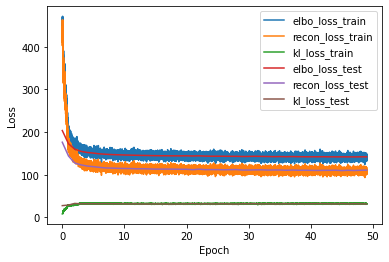

In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 128
EPOCHS = 50
LR = 0.0001

# ====

# change the path to the data
train_data, test_data = load_pickle(os.path.join('cifar10.pkl'))

# analyze the following code to understand what exactly happens here :)
train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')
test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), 16).cuda()
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)
samples = model.sample(100) * 255.

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

samples, reconstructions, interps = samples.astype('float32'), reconstructions.astype('float32'), interps.astype('float32')
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

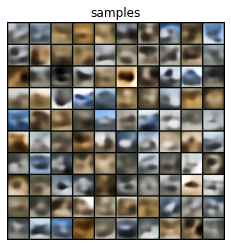

In [ ]:
show_samples(samples, 'samples')

## Task 3 (5 points): RealNVP on 2d data

In this task you will implement RealNVP model on 2d moons dataset. 

The following function generates the data (do not change it).

In [ ]:
def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

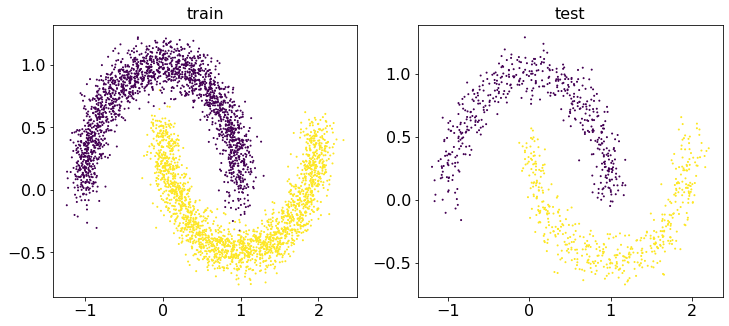

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

See original paper for model description (https://arxiv.org/abs/1605.08803).

The model is a sequence of affine coupling layers. Note that you have to permute the features that will left unchanged between different layers (change order of $\\mathbf{x}_1$ and $\mathbf{2}$ in formulas below).

Forward transform:
$$
    \begin{cases}
        \mathbf{y}_1 &= \mathbf{x}_1; \\
        \mathbf{y}_2 &= \mathbf{x}_2 \odot \exp (s(\mathbf{x}_1)) + t(\mathbf{x}_1).
    \end{cases} 
$$

Inverse transform:
$$
    \begin{cases}
        \mathbf{x}_1 &= \mathbf{y}_1; \\
        \mathbf{x}_2 &= (\mathbf{y}_2 - t(\mathbf{y}_1)) \odot \exp ( - s(\mathbf{y}_1)).
    \end{cases} 
$$

Here $s(\cdot)$ and $t(\cdot)$ are outputs of neural network.

In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, partition_type, n_hiddens):
        assert isinstance(n_hiddens, list)
        super().__init__()
        self.mask = self.build_mask(partition_type=partition_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = FullyConnectedMLP(input_shape=2, hiddens=n_hiddens, output_shape=2)

    def build_mask(self, partition_type):
        assert partition_type in {"left", "right"}
        # ====
        # your code
        # mask is extremely simple
        # it is a float tensor of two scalars (1.0 and 0.0)
        # the partition_type defines the order of these two scalars
        if partition_type == "left":
            mask = torch.FloatTensor([1.0, 0]).cuda()
        else:
            mask = torch.FloatTensor([0, 1.0]).cuda()
        
        # ====
        return mask

    def forward(self, x, invert=False):
        # ====
        # your code
        # you have to mask our input x
        # repeat mask batch_size times and apply x on mask
        mask = self.mask.repeat(x.shape[0], 1)
        x_masked = x * mask
        
        # ====

        # ====
        # your code
        # apply mlp to masked input to get log_s and t
        output = self.mlp(x_masked)
        log_s = output[:, :1]
        t = output[:, 1:]
        # ====

        # this formula is described in Section 4.1 in original paper
        # just left it unchanged
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        # note that we invert mask here
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        # ====
        # your code
        # if invert=True use reverse transform, else use forward transform
        if invert:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        # ====

        # the output is transformed input 
        # and logarithm of jacobian which equals to log_s
        return x, log_s


class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # base distribution is normal
        self.prior = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
        # ====
        # your code
        # apply sequence of AffineTransform with alternating partition_type
        # 6 layers is sufficient (with 2 hidden layers in each affine layer)
        self.transforms = nn.ModuleList([
            AffineTransform('left', [8, 8]),
            AffineTransform('right', [8, 8]),
            AffineTransform('left', [8, 8]),
            AffineTransform('right', [8, 8]),
            AffineTransform('left', [8, 8]),
            AffineTransform('right', [8, 8])
        ])
        # ====
        
    def forward(self, x, invert=False):
        z = x
        log_det = 0.0
        transforms = self.transforms[::-1] if invert else self.transforms

        for transform in transforms:
            #Тут ошибочка
            z, delta_log_det = transform(z, invert)
            log_det += delta_log_det

        return z, log_det

    def log_prob(self, x):
        # ====
        # your code
        # 1) make forward pass with right inverse flag
        # 2) sum log_det with log of base distribution
        z, log_det = self.forward(x)
        return torch.sum((-0.5) * z ** 2 + log_det, 1)
        # ====

    def loss(self, x):
        return {'nll_loss': -self.log_prob(x).mean()}

    def sample(self, n):
        # ====
        # your code
        # 1) sample from the prior
        # 2) apply the forward pass with the right inverse flag
        # 3) return only the first output of forward pass
        x = prior.sample((n, 2))
        x, _ = self.forward(x)
        return x
        # ====

Here the helper functions for visualization. Look at them carefully and do not change them.

In [ ]:
def show_2d_latents(latents, labels, title='Latent Space'):
    plt.figure()
    plt.title(title)
    plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.show()

def show_2d_densities(densities, title='Densities'):
    plt.figure()
    plt.title(title)
    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

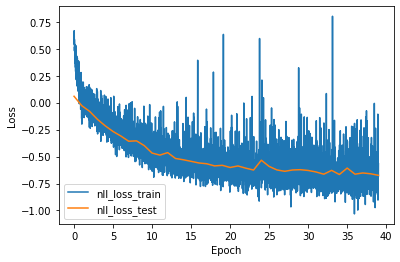

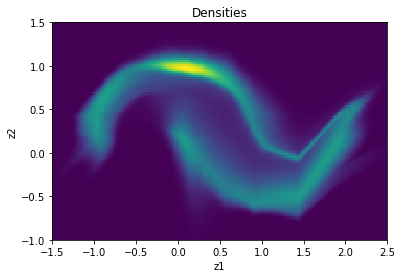

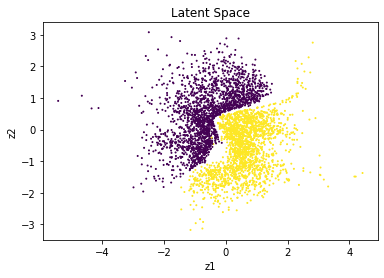

In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 32
EPOCHS = 40
LR = 1e-3

# ====

COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)

loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# model
real_nvp = RealNVP().cuda()

# train
train_losses, test_losses = train_model(
    real_nvp, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='nll_loss'
)

# heatmap
dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).cuda()
densities = np.exp(real_nvp.log_prob(mesh_xs).cpu().detach().numpy())

# latents
z = real_nvp(torch.FloatTensor(train_data).cuda())[0]
latents = z.cpu().detach().numpy()

plot_training_curves(train_losses, test_losses)
show_2d_densities(densities)
show_2d_latents(latents, train_labels)